In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm


In [2]:
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Adjust the input size based on the flattened size after conv layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust based on actual shape
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))

        # Print shape to check the output of conv layers
        print(x.shape)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [3]:
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Update the input size of fc1 to 65536 based on the output of conv2
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # 64 channels, 32x32 feature map
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flattening the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [4]:
def generate_spectrogram(y, sr=16000, n_fft=2048, hop_length=512):
    """Generate a mel-spectrogram from the audio signal."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

def save_spectrogram_image(S_dB, file_path):
    """Save a spectrogram as an image file."""
    plt.figure(figsize=(10, 4))
    ax = plt.gca()  # Get current axis
    img = librosa.display.specshow(S_dB, sr=16000, hop_length=512, x_axis='time', y_axis='mel', ax=ax)
    
    # Hide axes and colorbar for cleaner image
    ax.axis('off')
    fig = plt.gcf()  # Get current figure
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    # Save the image file
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

   


In [5]:
dataset_path = '../dataset_normalized'  # Adjust this path if needed
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio segments and their corresponding labels
audio_segments = []
tempo_labels = []

for file in tqdm(audio_files, desc='Generating spectrograms'):
    y, sr = librosa.load(file, sr=16000)
    S_dB = generate_spectrogram(y, sr)
    
    # Save each spectrogram as an image
    image_path = file.replace('.wav', '.png')  # Save images as .png in the same structure
    save_spectrogram_image(S_dB, image_path)
    audio_segments.append(image_path)

# Dummy tempo labels (replace with your actual tempo data if available)
tempo_labels = np.random.uniform(low=50, high=150, size=len(audio_segments))


Generating spectrograms:   0%|          | 0/615 [00:00<?, ?it/s]

In [86]:
# Define transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create Dataset and DataLoader
train_dataset = SpectrogramDataset(audio_segments, tempo_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation set (optional, could be split from the train_dataset)
val_dataset = SpectrogramDataset(audio_segments, tempo_labels, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [87]:
# Function to plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="red")
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.show()

# Function to visualize predicted vs. true tempos
def plot_predicted_vs_true(model, val_dataloader, max_tempo):
    model.eval()
    true_tempos = []
    predicted_tempos = []

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_images)

            # Collect true and predicted tempos
            true_tempos.extend(val_labels.cpu().numpy())
            predicted_tempos.extend(outputs.squeeze().cpu().numpy())

    # Rescale the predicted and true tempos back to the original tempo range
    true_tempos_rescaled = [t * max_tempo for t in true_tempos]
    predicted_tempos_rescaled = [p * max_tempo for p in predicted_tempos]

    # Compute Mean Absolute Error for tempo predictions
    mae = mean_absolute_error(true_tempos_rescaled, predicted_tempos_rescaled)
    print(f"Mean Absolute Error in Tempo Prediction: {mae:.2f} BPM")

    # Plot True vs Predicted Tempos
    plt.figure(figsize=(8, 6))
    plt.scatter(true_tempos_rescaled, predicted_tempos_rescaled, alpha=0.7)
    plt.plot([min(true_tempos_rescaled), max(true_tempos_rescaled)],
             [min(true_tempos_rescaled), max(true_tempos_rescaled)], 'r--')  # Ideal prediction line
    plt.xlabel('True Tempo (BPM)')
    plt.ylabel('Predicted Tempo (BPM)')
    plt.title('True vs. Predicted Tempo')
    plt.show()


In [88]:
def train_model_with_visualization(model, train_dataloader, val_dataloader, num_epochs=50, patience=10, max_tempo=1.0):
    # Define optimizer and loss function
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)

    # Track losses and early stopping
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, labels in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            # Remove the squeeze call
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_images, val_labels in val_dataloader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = model(val_images)
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")
            counter = 0
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epoch(s).")
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plot_loss(train_losses, val_losses)

    # Plot predicted vs true tempo for the validation set
    plot_predicted_vs_true(model, val_dataloader, max_tempo)

    return train_losses, val_losses


In [89]:
checkpoint_dir = 'checkpoints_visual_model'
best_model_path = os.path.join(checkpoint_dir, 'best_visual_model.pth')

# Create directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the best model for further training or evaluation
def load_best_model(model):
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()
    print(f"Best model loaded from {best_model_path} for further training or evaluation.")


!!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




Epoch 1/50:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/rrenoir/miniforge3/envs/aicp/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/rrenoir/miniforge3/envs/aicp/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [1/50], Train Loss: 98.6812, Val Loss: 97.8387
Best model saved with validation loss: 97.8387


Epoch 2/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 98.2165, Val Loss: 97.8387
Best model saved with validation loss: 97.8387


Epoch 3/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 98.4756, Val Loss: 97.8387
No improvement in validation loss for 1 epoch(s).


Epoch 4/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 97.7896, Val Loss: 97.8387
No improvement in validation loss for 2 epoch(s).


Epoch 5/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 98.0754, Val Loss: 97.8387
No improvement in validation loss for 3 epoch(s).


Epoch 6/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 97.5082, Val Loss: 97.8387
No improvement in validation loss for 4 epoch(s).


Epoch 7/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 98.8147, Val Loss: 97.8387
No improvement in validation loss for 5 epoch(s).


Epoch 8/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 98.4781, Val Loss: 97.8387
No improvement in validation loss for 6 epoch(s).


Epoch 9/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 98.7981, Val Loss: 97.8387
No improvement in validation loss for 7 epoch(s).


Epoch 10/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 98.5148, Val Loss: 97.8387
No improvement in validation loss for 8 epoch(s).


Epoch 11/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 98.1293, Val Loss: 97.8387
No improvement in validation loss for 9 epoch(s).


Epoch 12/50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 97.9305, Val Loss: 97.8387
No improvement in validation loss for 10 epoch(s).
Early stopping triggered.


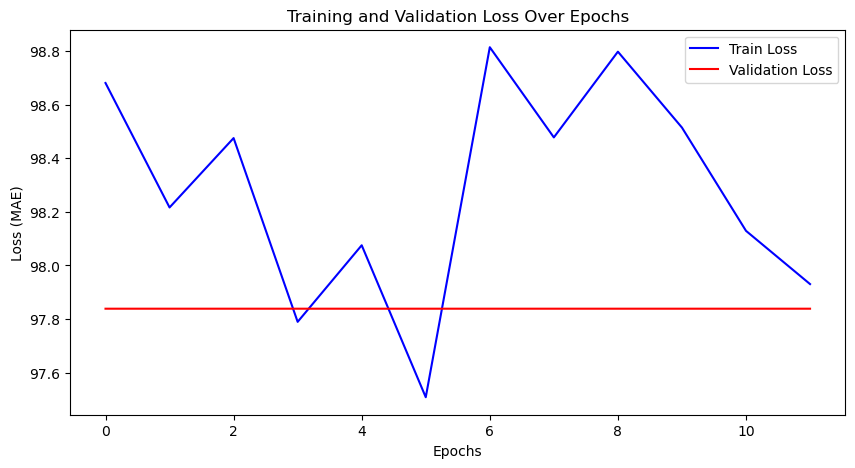

Mean Absolute Error in Tempo Prediction: 14734.80 BPM


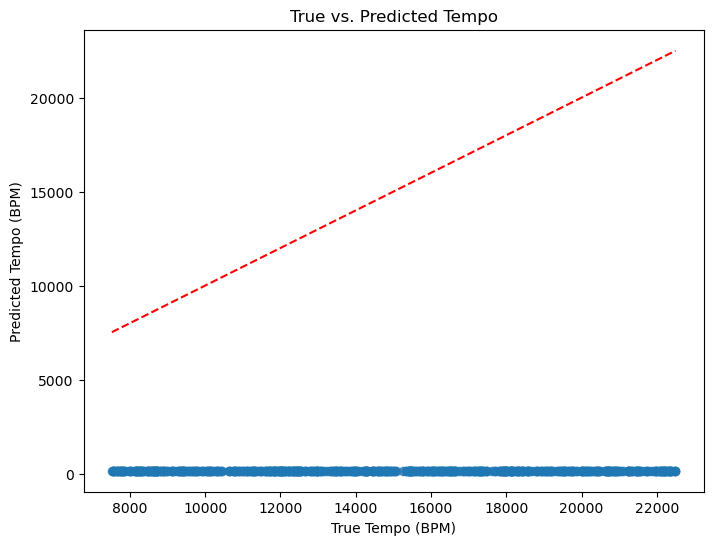

Best model loaded from checkpoints_visual_model/best_visual_model.pth for further training or evaluation.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_33265/2096894196.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

In [93]:
# Initialize model, device, and other parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectrogramCNN()

# Set the maximum tempo for rescaling during predictions
max_tempo = np.max(tempo_labels)

# Train the model and visualize
train_model_with_visualization(model, train_dataloader, val_dataloader, num_epochs=50, patience=10, max_tempo=max_tempo)

# Optionally load the best model for further training or evaluation
load_best_model(model)


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data